## Compton Scattering from a Copper Rod

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sig
import scipy.stats as stat
import scipy.constants as constants

In [63]:
# fundamental constants 
c = constants.c
e = constants.e
m_e = constants.m_e
N_A = constants.N_A
eps_0 = constants.epsilon_0

In [64]:
# Importing data into Pandas DataFrame
Cu_130 = pd.read_csv("Cu/50angle6hr.csv")
Cu_110 = pd.read_csv("Cu/70angle6hr.csv")
Cu_100 = pd.read_csv("Cu/80angle9hr.csv")
Cu_90 = pd.read_csv("Cu/90angle5hr.csv")
Cu_70 = pd.read_csv("Cu/110angle9hr.csv")
Cu_50 = pd.read_csv("Cu/130angle5hr.csv")
Cu_30 = pd.read_csv("Cu/150angle150min.csv")
Cu_10 = pd.read_csv("Cu/170angle1hr.csv")
Cu_0 = pd.read_csv("Cu/0angle1hr.csv")

In [65]:
df_list = [Cu_130, Cu_110, Cu_100, Cu_90, Cu_70, Cu_50, Cu_30, Cu_10, Cu_0]
for df in df_list: # Renaming columns
    df.rename(columns={'   Channel':'Channel', '  Energy(keV)':'Energy', '   Counts':'Counts'},inplace=True)

In [66]:
angles_deg = [130, 110, 100, 90, 70, 50, 30, 10, 0]
angles = [np.radians(angle) for angle in angles_deg] # angles in radians
times = [6, 6, 9, 5, 9, 5, 2.5, 1.2, 0.8] # in hours

In [67]:
def polyfit(x_list, m, b): # fits m*x+b to list of x values
    return [m*x + b for x in x_list]

In [68]:
m, b = 1.7561914146976987, -6.763325535092946 # calibration - see 'calibration' file
binwidth = (max(Cu_0['Channel']) - min(Cu_0['Channel']))*m/1024

for df in df_list:
    df['Energy'] = polyfit(df['Channel'], m, b) # remapping Channel number onto energy

In [69]:
def smooth(df, Wn): # applies low-pass filter to Counts column of dataframe df, with critical frequency Wn
    b, a = sig.butter(2, Wn, 'lp')
    return sig.filtfilt(b, a, df['Counts'])

def smooth_peaks(df, Wn, prom): # finds energy positions of peaks in smoothed data with prominence prom
    peak_info = sig.find_peaks(smooth(df, Wn), prominence=prom)
    return [list(df['Energy'][peak_info[0]]), list(smooth(df, Wn)[peak_info[0]])]

def peak_indices(df, Wn, prom): # finds indices of peaks 
    return sig.find_peaks(smooth(df, Wn), prominence=prom)[0]

def peak_int(df, end): # uses trapezium rule to integrate half of peak, multiply by 2, minus background below peak
    start = peak_indices(df, 0.33, 300)[-1]
    square = (df['Energy'][end] - df['Energy'][start])*df['Counts'][end]
    return np.trapz(df['Counts'][start:end], df['Energy'][start:end])*2 - square*2  

def peak_int_err(df, end, end_min): # diff between min area and nominal area always larger due to shape of peak
    # from difference in counts between nominal count value and 'pessimistic' count value
    return peak_int(df, end) - peak_int(df, end_min) # uncertainty from uncertainty in peak pos negligible 

def smooth_plot(df, Wn, prom, xlim): # plots raw and smoothed data including marking peaks with x
    plt.figure(figsize=(19,8))
    plt.plot(df['Energy'], df['Counts'], color='k')
    plt.plot(df['Energy'], smooth(df, Wn), color='r')
    plt.scatter(smooth_peaks(df, Wn, prom)[0], smooth_peaks(df, Wn, prom)[1], marker='x', color='b', s=40)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Counts")
    plt.xlim(xlim)

In [70]:
E_gamma = []
for df in df_list:
    E_gamma.append(smooth_peaks(df, 0.3, 180)[0][-1]) # list of scattered E gamma values - final photopeak 

angle_err = np.radians(0.05) #negligible
peak_x_err = [4, 5, 6, 6, 6, 4, 2, 3, 3] # error in peak position in units of energy bin widths (excluding effect of binning itself) not including theta=130
E_gamma_err = [(err + 1)*binwidth for err in peak_x_err] # error in peak E in keV including effecting of binning 

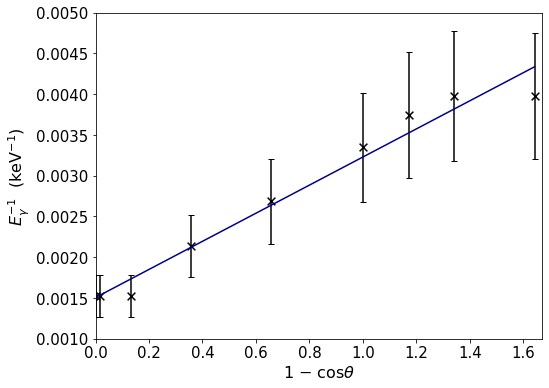

In [71]:
plt.figure(figsize=(8,6))
plt.scatter([1-np.cos(angle) for angle in angles], [E**-1 for E in E_gamma], color='k', marker='x', s=60)
plt.errorbar([1-np.cos(angle) for angle in angles], [E**-1 for E in E_gamma], 
             yerr = [((E_err/E)+0.16)/E for E, E_err in zip(E_gamma, E_gamma_err)],linestyle='',color='k',capsize=3)
m, b, r_value, p_value, stderr = stat.linregress([1-np.cos(angle) for angle in angles], [E**-1 for E in E_gamma])
plt.plot([1-np.cos(angle) for angle in angles], 
         polyfit([1-np.cos(angle) for angle in angles], m, b), color='darkblue')
plt.xlim(0,1.67)
plt.ylim(0.001,0.005)
plt.xlabel('1 $-$ cos$\\theta$', size=16)
plt.ylabel("$E_{\\gamma}^{-1}$  (keV$^{-1}$)", size=16)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [72]:
x, y = np.array([1-np.cos(angle) for angle in angles]), np.array([E**-1 for E in E_gamma])
residuals = [yval - (m * xval + b) for xval, yval in zip(x, y)]
m_err = np.sqrt(sum([R**2 for R in residuals]))
b_err = m_err/np.sqrt(len(angles))

e_RME, e_RME_err = 1/m, m_err/m**2
Ei_gamma, Ei_gamma_err = 1/b, b_err/b**2

print("Electron rest mass energy (keV) =", e_RME, "+/-", e_RME_err) # value from literature = 511 keV
print("Energy of gamma emitted by 137-Cs (keV) =", Ei_gamma, "+/-", Ei_gamma_err) # value from literature = 662 keV

Electron rest mass energy (keV) = 580.3603882743532 +/- 171.52915415425906
Energy of gamma emitted by 137-Cs (keV) = 663.9393186489583 +/- 74.8303786835983


### Differential Scattering Cross Section

In [73]:
'''Defining parameters for the differential scattering cross section'''

eff = [0.325, 0.325, 0.3, 0.27, 0.22, 0.15, 0.09, 0.09, 0.09] # intrinsic detector efficiency - from graph in script

t_now = 22.5 # 22.5 years since activity was taken to march 2024
activity = 24.7*1e6*np.exp(-np.log(2)/30*t_now) # half-life of Cs = 30 years, activity 24.7MBq measured on 01/09/2001

D_det = 0.02 # diameter of open area of detector
A_det = np.pi*(D_det*0.5)**2 # open area of detector
d_rd = 0.3 # distance from scatter to detector 
d_sr = 0.3 # distance from source to rod 
d_sa = 0.04 # distance from source to lead aperture
D_rod = 0.025 # diameter of rod (from script)
D_ap = 12.5e-3 # diameter of aperture (from script)

A_irrad = np.pi*(D_ap*0.5)**2/d_sa**2*d_sr**2 # 'irradiated spherical area' of rod
V_irrad = A_irrad*D_rod*0.7 # irradiated volume of rod 

I = (A_irrad/4*np.pi*d_sr**2)*activity/d_sr**2 # N of gammas incident on rod per sqm per s
                                            # assuming inverse square relationship between activity and distance

Cu_density = 8.94e3 # density of copper in kg per m3
N_e = 2*Cu_density*V_irrad/63.5e-3*N_A # N of electons in 'irradiated volume' of rod 
                                        # assuming each Cu can lose 2 electrons

In [74]:
'''Determining uncertainty in parameters'''
eff_err = [0.025, 0.025, 0.025, 0.025, 0.02, 0.01, 0.005, 0.005, 0.005] # uncertainty in efficiency - from reading graph

t_now_err = 1.5/12 # experiment was done over the course of about 6 weeks
activity_err = np.log(2)/30*24.7*1e6*np.exp(-np.log(2)/30*t_now)*t_now_err # error in activity from error in time

D_det_err = 0.1e-3
d_rd_err = 0.02
d_sr_err = 0.02
d_sa_err = 0.004
D_rod_err = 1e-3 
D_ap_err = 0.01e-3

A_det_err = (np.pi*D_det*0.5)*D_det_err

A_irrad_err = np.sqrt((np.pi*D_ap*0.5/d_sa**2*d_sr**2*D_ap_err)**2 # negligible
                      + (2*np.pi*(D_ap*0.5)**2/d_sa**3*d_sr**2*d_sa_err)**2
                      + (2*np.pi*(D_ap*0.5)**2/d_sa**2*d_sr**3*d_sr_err)**2) #negligible

V_irrad_err = np.sqrt((A_irrad_err/A_irrad)**2 + (D_rod_err/D_rod)**2)*V_irrad

I_err = np.sqrt(((1/4*np.pi*d_sr**2)*activity/d_sr**2*A_irrad_err)**2
                + ((4*A_irrad/4*np.pi*d_sr**5)*activity*d_sr_err)**2
                + ((A_irrad/4*np.pi*d_sr**2)*activity_err/d_sr**2)**2)

N_e_err = np.sqrt((V_irrad_err/V_irrad)**2 + (D_rod_err/D_rod)**2)*N_e

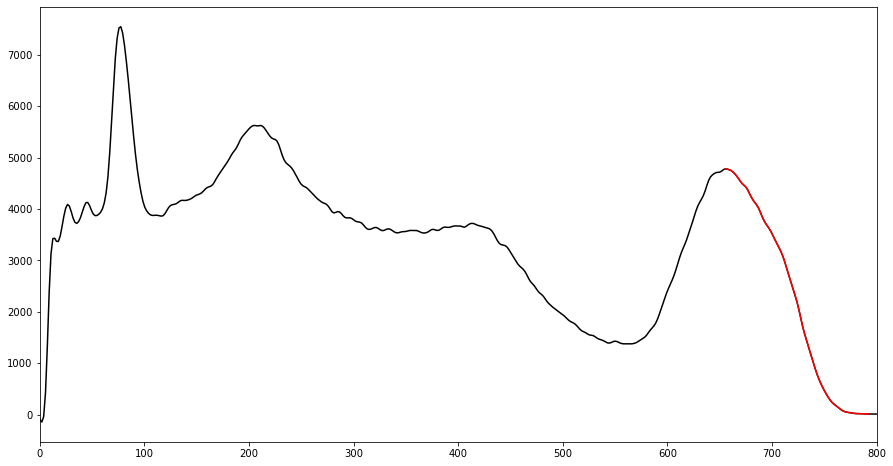

In [93]:
def check_peak_range(df, peak_tail, Wn, prom, xlim): # visualizes spectrum to manually identify peak start and end
    plt.figure(figsize=(15,8))
    plt.plot(df['Energy'], smooth(df, Wn), color='k')
    peak_start = peak_indices(df, Wn, prom)[-1]
    plt.plot(df['Energy'][peak_start:peak_tail], smooth(df, Wn)[peak_start:peak_tail], color='r')
    plt.xlim([0,xlim])

check_peak_range(Cu_0, 455, 0.3, 300, 800)

In [42]:
'''Integrated photopeak count for each angle'''
C_0 = peak_int(Cu_0, 455)
C_10 = peak_int(Cu_10, 450)
C_30 = peak_int(Cu_30, 445)
C_50 = peak_int(Cu_50, 350)
C_70 = peak_int(Cu_70, 290)
C_90 = peak_int(Cu_90, 260)
C_100 = peak_int(Cu_100, 240)
C_110 = peak_int(Cu_110, 220)
C_130 = peak_int(Cu_130, 220)

peak_count = [C_130, C_110, C_100, C_90, C_70, C_50, C_30, C_10, C_0]

In [43]:
'''Photopeak count error'''
C_0_err = peak_int_err(Cu_0, 455, 450)
C_10_err = peak_int_err(Cu_10, 450, 445)
C_30_err = peak_int_err(Cu_30, 445, 440)
C_50_err = peak_int_err(Cu_50, 350, 340)
C_70_err = peak_int_err(Cu_70, 290, 280)
C_90_err = peak_int_err(Cu_90, 260, 250)
C_100_err = peak_int_err(Cu_100, 230, 220)
C_110_err = peak_int_err(Cu_110, 220, 210)
C_130_err = peak_int_err(Cu_130, 220, 210)

peak_count_err = [C_130_err, C_110_err, C_100_err, C_90_err, C_70_err, C_50_err, C_30_err, C_10_err, C_0_err]

In [45]:
def diff_xsect (C,eff,t): # experimentally determined x section as a function of photopeak count, detector efficiency, and scan time
    return C*d_rd/(t*eff*N_e*I*A_det)

def diff_xsect_relerr (C, C_err, eff, eff_err): # relative uncertainty in experimentally determined x section
    params = [C, eff, A_det, N_e, d_rd, I]
    params_err = [C_err, eff_err, A_det_err, N_e_err, d_rd_err, I_err]
    return sum([err**2/param**2 for param, err in zip(params, params_err)])**0.5

def klein_nishina(E_g, theta): # Klein-Nishina formula for x section
    a = E_g*e/(m_e*c**2)
    r0 = e**2/(4*np.pi*eps_0*m_e*c**2)
    brac1 = (1 + np.cos(theta)**2)/(1 + a*(1 - np.cos(theta)))**2
    brac2= 1 + (a*(1-np.cos(theta)))**2/((1+np.cos(theta)**2)*(1+a*(1-np.cos(theta))))
    return brac1*brac2*r0**2/2

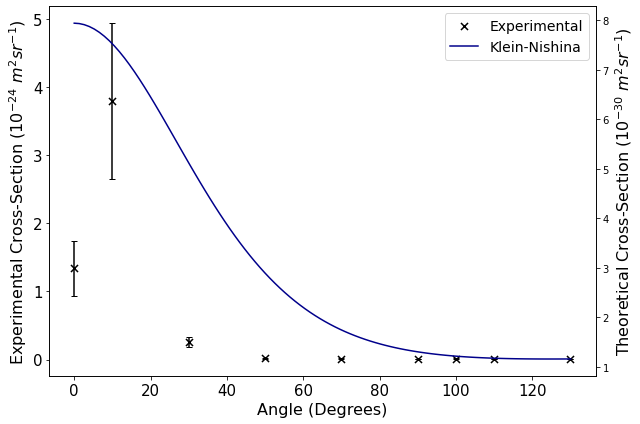

In [54]:
fig, ax1 = plt.subplots(figsize=(9,6))
ax1.scatter(angles_deg,[1e24*diff_xsect(cnt, ef, t*60**2) for cnt, ef, t in zip(peak_count, eff, times)], s=50, color='k', marker='x', label = 'Experimental')
ax1.errorbar(angles_deg, [1e24*diff_xsect(cnt, ef, t*60**2) for cnt, ef, t in zip(peak_count, eff, times)], 
             yerr = [1e24*(diff_xsect_relerr(cnt, cnt_err, ef, ef_err))*diff_xsect(cnt,ef,t*60**2) 
                     for cnt, cnt_err, ef, ef_err, t in zip(peak_count, peak_count_err, eff, eff_err, times)], 
            linestyle='',color='k',capsize=3)
ax1.set_xlabel('Angle (Degrees)',size=16)
ax1.set_ylabel('Experimental Cross-Section ($10^{-24}$ $m^2sr^{-1}$)',size=16)
ax1.tick_params(axis='both',labelsize=15)

ax2 = ax1.twinx()
ax2.set_ylabel('Theoretical Cross-Section ($10^{-30}$ $m^2sr^{-1}$)',size=16)
theta = np.linspace(0, 2.27, 100)
ax2.plot(theta*360/(np.pi*2),[1e30*klein_nishina(662*1e3,thet) for thet in theta], color='darkblue', label = 'Klein-Nishina')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0, fontsize=14)

fig.tight_layout()
plt.show()

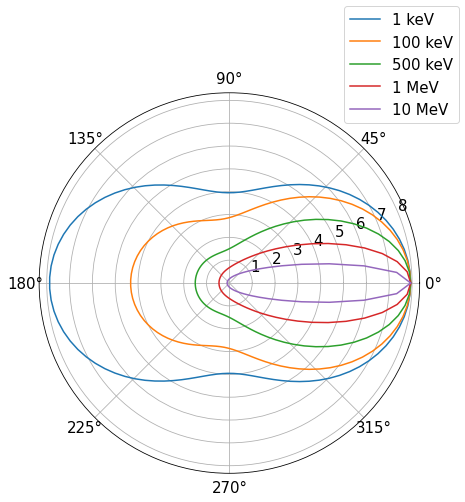

In [49]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))

theta = np.linspace(0, 2*np.pi, 100)

for Eg, Elabel in zip([1e3, 100e3, 500e3, 2e6, 10e6], ['1 keV', '100 keV', '500 keV', '1 MeV', '10 MeV']):
    ax.plot(theta, [1e30*klein_nishina(Eg, t) for t in theta], label=str(Elabel))


ax.legend(fontsize=15, loc=(0.8,.92))
ax.tick_params(labelsize=15)
ax.grid(True)
plt.show()